# Курсовой проект для курса "Python для Data Science"

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: **Price**

Метрика: **R2 - коэффициент детерминации** (sklearn.metrics.r2_score)

# Описание датасета



**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

# Загружаем библиотеки

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from pylab import rcParams

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истинные значения')
    plt.title('Истинные vs Прогнозируемые значения')
    plt.show()
    
    

# Пути к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'Artemev_predictions.csv '

# Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

# Анализ данных датасетов

In [6]:
train_df.shape

(10000, 20)

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Явно заметно наличие выбросов в количестве комнат, площадях, годах постройки дома. 
  Helthcare_2 - скорее относится к категориальным признакам. Показатели местности Social, и Shops интерпретировать трудно.

Посмотрим на выбросы: Исспользуем логарифмическую шкалу, для того, чтобы ящики не были слишком узкими.

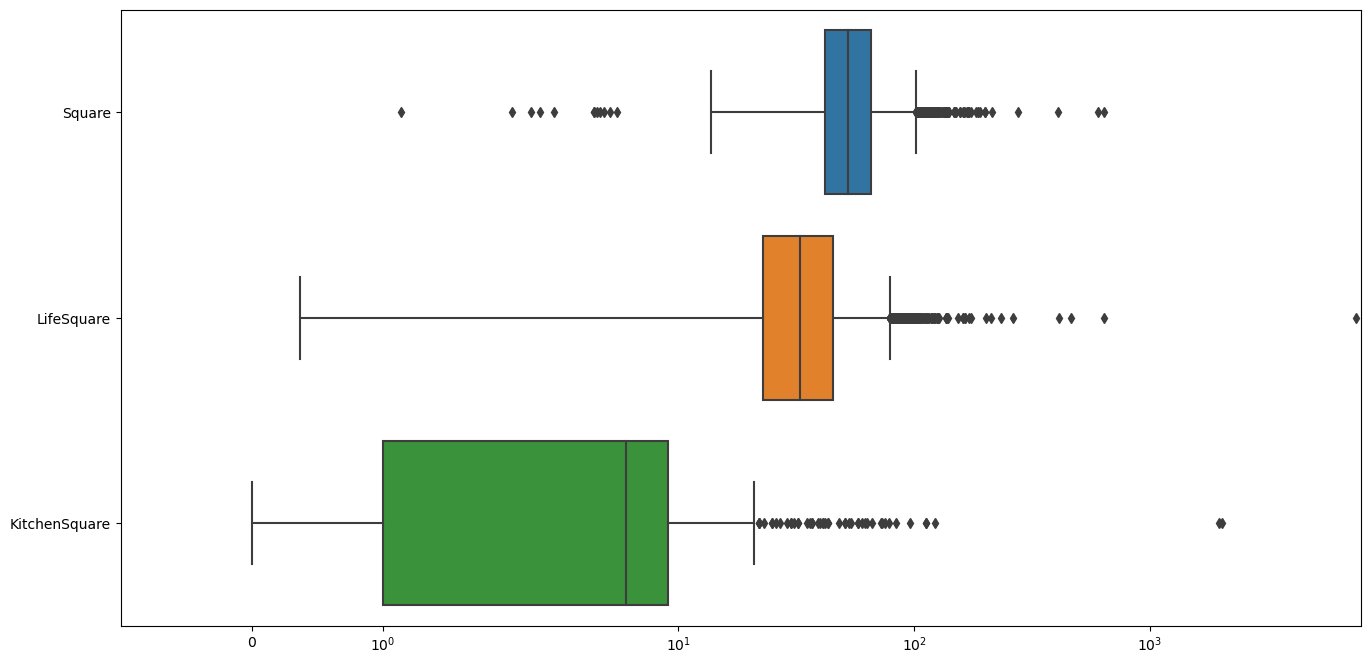

In [10]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_df[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

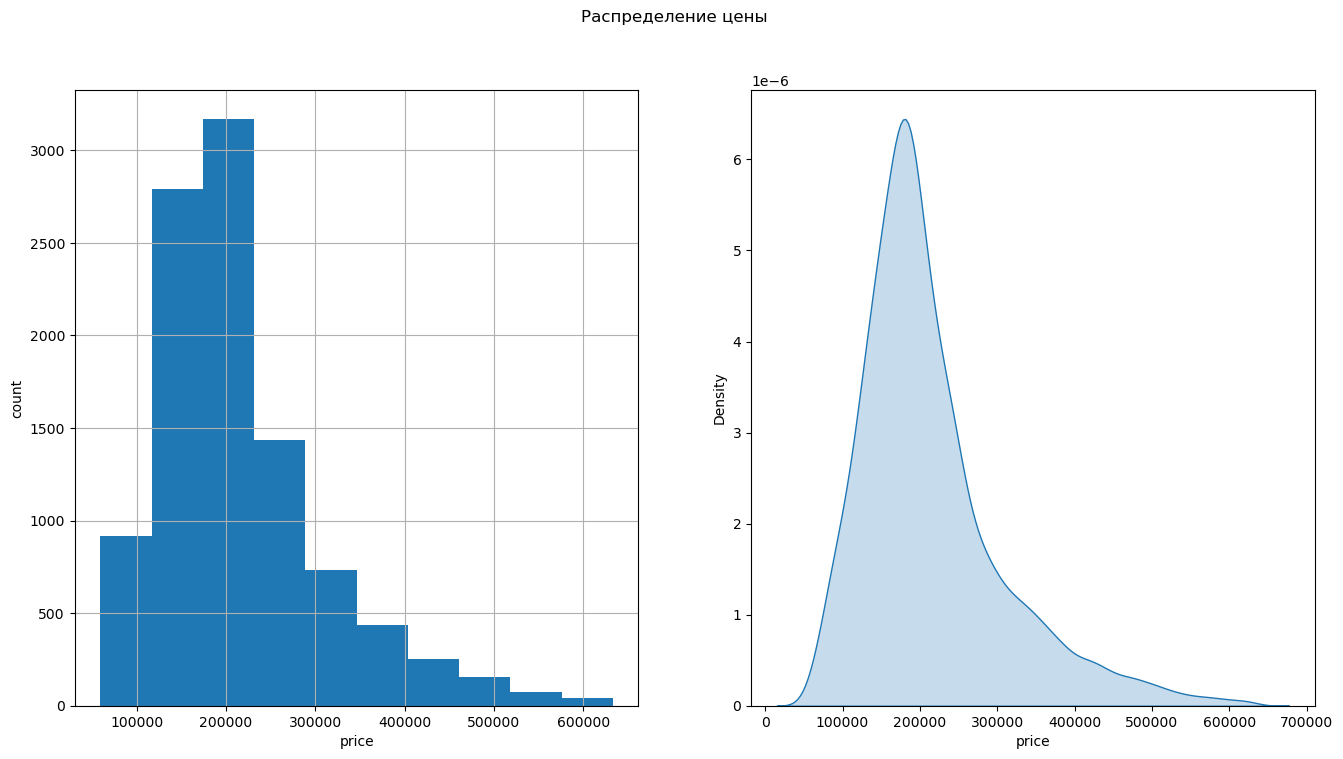

In [11]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

# Подготовка обучающего датасета

Приведем к строковому типу признаки Id и DistrictId

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [16]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Работа с пропусками

# LifeSquare

Поскольку пропусков по признаку Square у нас нет, попробуем заполнить пропуски значений LifeSquare, исходя из среднего отношения между этими признаками

In [17]:
LifeSquare_relation = np.mean(train_df['LifeSquare'] / train_df['Square']) 

LifeSquare_relation_t = np.mean(test_df['LifeSquare'] / test_df['Square']) 

In [18]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] * LifeSquare_relation
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] * LifeSquare_relation_t

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Helthcare_1

In [20]:
pd.concat([train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('DistrictId')['Healthcare_1'].count(),
          train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False).head(10)

,mean,std,count,nans
DistrictId,,,,
27,NaN,NaN,0,851
1,228.77193,17.973682,57,595
23,0.00000,0.000000,1,564
62,2300.00000,0.000000,9,238
45,NaN,NaN,0,116
34,NaN,NaN,0,111
61,80.00000,0.000000,8,110
13,1406.00000,0.000000,4,93
9,30.00000,0.000000,202,92


In [21]:
pd.concat([train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].count(),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Helthcare_2,,,,
0,1007.781176,913.614469,1275,2939
1,811.362162,696.540435,925,1258
3,1363.377877,1005.678878,1347,323
5,1824.089623,1574.227572,212,176
2,1010.708333,1045.440449,1056,102
4,1929.229167,1121.872942,288,0
6,645.000000,0.000000,99,0


In [22]:
pd.concat([test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          test_df.groupby('Helthcare_2')['Healthcare_1'].count(),
          test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Helthcare_2,,,,
0,976.073463,905.416376,667,1429
1,836.115385,738.358386,442,654
3,1353.301429,1064.113455,700,155
5,1606.402062,1528.202594,97,89
2,1095.586538,1135.975340,520,50
4,1829.658228,1086.820049,158,0
6,645.000000,0.000000,39,0


In [23]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [24]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [25]:
test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(test_df.groupby('Helthcare_2')['Healthcare_1'].transform('mean'))

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

# Работаем с выбросами признака "Rooms"

In [28]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [29]:
train_df[train_df['Rooms'] <=0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,3097,0,1007.781176,0,0,B,268394.744389,1,1,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,1007.781176,0,1,B,302211.260887,1,1,1
2269,7317,27,0.0,41.790881,27.827912,0.0,13,0.0,1977,0.211401,...,1892,0,1007.781176,0,1,B,98129.976788,1,1,1
3911,770,28,0.0,49.483501,32.950310,0.0,16,0.0,2015,0.118537,...,6207,1,1183.000000,1,0,B,217009.338463,1,1,1
4366,456,6,0.0,81.491446,54.263914,0.0,4,0.0,1977,0.243205,...,1564,0,540.000000,0,0,B,212864.799112,1,1,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,469,0,1007.781176,0,0,B,126596.941798,1,1,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,8429,3,1363.377877,3,9,B,158998.110646,1,1,1
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,1892,0,1007.781176,0,1,B,219281.918007,1,1,1


In [30]:
train_df[train_df['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,19083,2,1824.089623,5,15,B,317265.323792,1,1,1
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,264,0,1007.781176,0,1,B,78364.616704,1,1,1
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,5648,1,30.000000,2,4,B,172329.270863,1,1,1


In [31]:
train_df.loc[(train_df['Rooms'] > 6)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 6)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]

# Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"

In [32]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        37.831065
std         76.916897
min          0.370619
25%         24.813113
50%         33.602768
75%         45.251683
max       7480.592129
Name: LifeSquare, dtype: float64

In [33]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [34]:
kitchsq_med = train_df['KitchenSquare'].median()
KitchenSquare_max = np.quantile(train_df['KitchenSquare'], q=0.975)
lifesq_med = train_df['LifeSquare'].median()
LifeSquare_max = np.quantile(train_df['LifeSquare'], q=0.975)
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] > LifeSquare_max, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] > KitchenSquare_max, 'KitchenSquare'] = kitchsq_med

test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] > LifeSquare_max, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] > KitchenSquare_max, 'KitchenSquare'] = kitchsq_med


# Работаем с выбросами признака "Square"

In [35]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [36]:
Square_max = np.quantile(train_df['Square'], q=0.975)
square_med = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_med
train_df.loc[train_df['Square'] > Square_max, 'Square'] = square_med

test_df.loc[test_df['Square'] < 16, 'Square'] = square_med
test_df.loc[test_df['Square'] > Square_max, 'Square'] = square_med

In [37]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,54.560579,35.974818,7.186500
std,15.714997,12.960540,1.901073
min,16.117154,10.523868,3.000000
25%,41.800063,26.059917,6.000000
50%,52.513310,33.602768,6.000000
75%,64.591720,44.223695,8.000000
max,100.904263,79.641684,13.000000


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Работаем с выбросами признака "HouseYear"

In [39]:
train_df[train_df['HouseYear'] > 2023]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.603096,1,1,1


In [40]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] >2023, 'HouseYear'] = 2023

# Работаем с выбросами признаков "Floor" и "HouseFloor"

In [41]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [42]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [43]:
train_df.loc[train_df['HouseFloor'] > 95, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 95, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [44]:
ind_train = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind_train, 'Floor'] = train_df.loc[ind_train, 'HouseFloor']

ind_test = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind_test, 'Floor'] = test_df.loc[ind_test, 'HouseFloor']

# Вычисляем "m_2_Price" - стоимость квадратного метра общей площади

In [45]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']


На его основе создаем новые признаки m_2_MedPriceByDistrict - медианная стоимость квадратного метра в зависимости от района и m_2_MedPriceByHouseYear - медианная стоимость квадратного метра в зависимости от возраста дома

In [46]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})


# Добавляем новые признаки к датасету

In [47]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left').set_index(train_df.index)
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left').set_index(train_df.index)

test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left').set_index(test_df.index)


train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,3854.958571,4358.274853,4473.255408
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,4567.491245,4437.304072,4317.685445
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,4915.149522,4862.207469,4429.204254
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,3291.591637,2988.442425,2932.820032
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,3788.892642,3992.031265,4367.263383


In [48]:
test_df[test_df['m_2_MedPriceByHouseYear'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
2,5480,190,1.0,52.513310,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.000000,5,5,B,1,1,1,8645.171143,NaN
64,3726,161,1.0,52.708494,20.502345,11.0,3,7.0,1911,0.014423,...,4,1010.708333,0,3,B,1,1,1,4893.010481,NaN
523,5118,155,3.0,73.259797,53.265370,10.0,3,5.0,1926,0.042307,...,9,4849.000000,3,6,B,1,1,1,5953.798366,NaN
836,9501,124,4.0,52.513310,72.739467,9.0,8,8.0,1943,0.169091,...,10,1007.781176,2,5,B,1,1,1,5002.224615,NaN
1482,16379,168,2.0,55.023181,30.940010,7.0,2,5.0,1926,0.341072,...,48,2300.000000,3,11,B,1,1,1,4935.309466,NaN
1951,11269,97,4.0,86.600121,56.311116,9.0,5,8.0,1943,0.306977,...,14,1575.000000,5,7,B,1,1,1,4942.568587,NaN
2086,732,27,3.0,77.661641,47.437166,6.0,6,6.0,1927,0.041116,...,4,811.362162,1,4,B,1,1,1,2772.078641,NaN
3253,12316,183,5.0,52.513310,33.602768,12.0,7,8.0,1908,0.246624,...,45,1010.708333,3,6,B,1,1,1,5810.399150,NaN
3571,6204,116,2.0,70.635171,43.274951,6.0,6,6.0,1927,0.341072,...,48,2300.000000,3,11,B,1,1,1,6085.149677,NaN
4159,9111,196,3.0,75.567065,50.680548,9.0,4,4.0,1927,0.000000,...,87,4702.000000,5,5,B,1,1,1,7149.180513,NaN


In [49]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,54.560579,35.974818,7.186500,7.934200,13.040300,1984.871800,0.118858,24.687000,5352.157400,...,1079.245456,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3986.437784,3957.289464,3811.384374
std,0.812096,15.714997,12.960540,1.901073,5.207397,6.276338,18.415447,0.119025,17.532614,4006.799803,...,753.549205,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1388.709486,1004.521728,752.389219
min,1.000000,16.117154,10.523868,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2298.367047,2810.203797
25%,1.000000,41.800063,26.059917,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,811.362162,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2958.121047,2938.048239,2932.820032
50%,2.000000,52.513310,33.602768,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,...,1007.781176,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3950.335589,4134.353749,4285.794408
75%,2.000000,64.591720,44.223695,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,1084.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4740.155440,4617.234701,4409.376396
max,6.000000,100.904263,79.641684,13.000000,42.000000,48.000000,2023.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11949.828980,8700.768533,7823.822055


# Заполняем пропуски на test

In [50]:
test_df.loc[test_df['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] = m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()
test_df['m_2_MedPriceByDistrict'].isnull().sum()

0

In [51]:
test_df.loc[test_df['m_2_MedPriceByHouseYear'].isnull(), 'm_2_MedPriceByHouseYear'] = m_2_MedPriceByHouseYear['m_2_MedPriceByHouseYear'].median()
test_df['m_2_MedPriceByHouseYear'].isnull().sum()

0

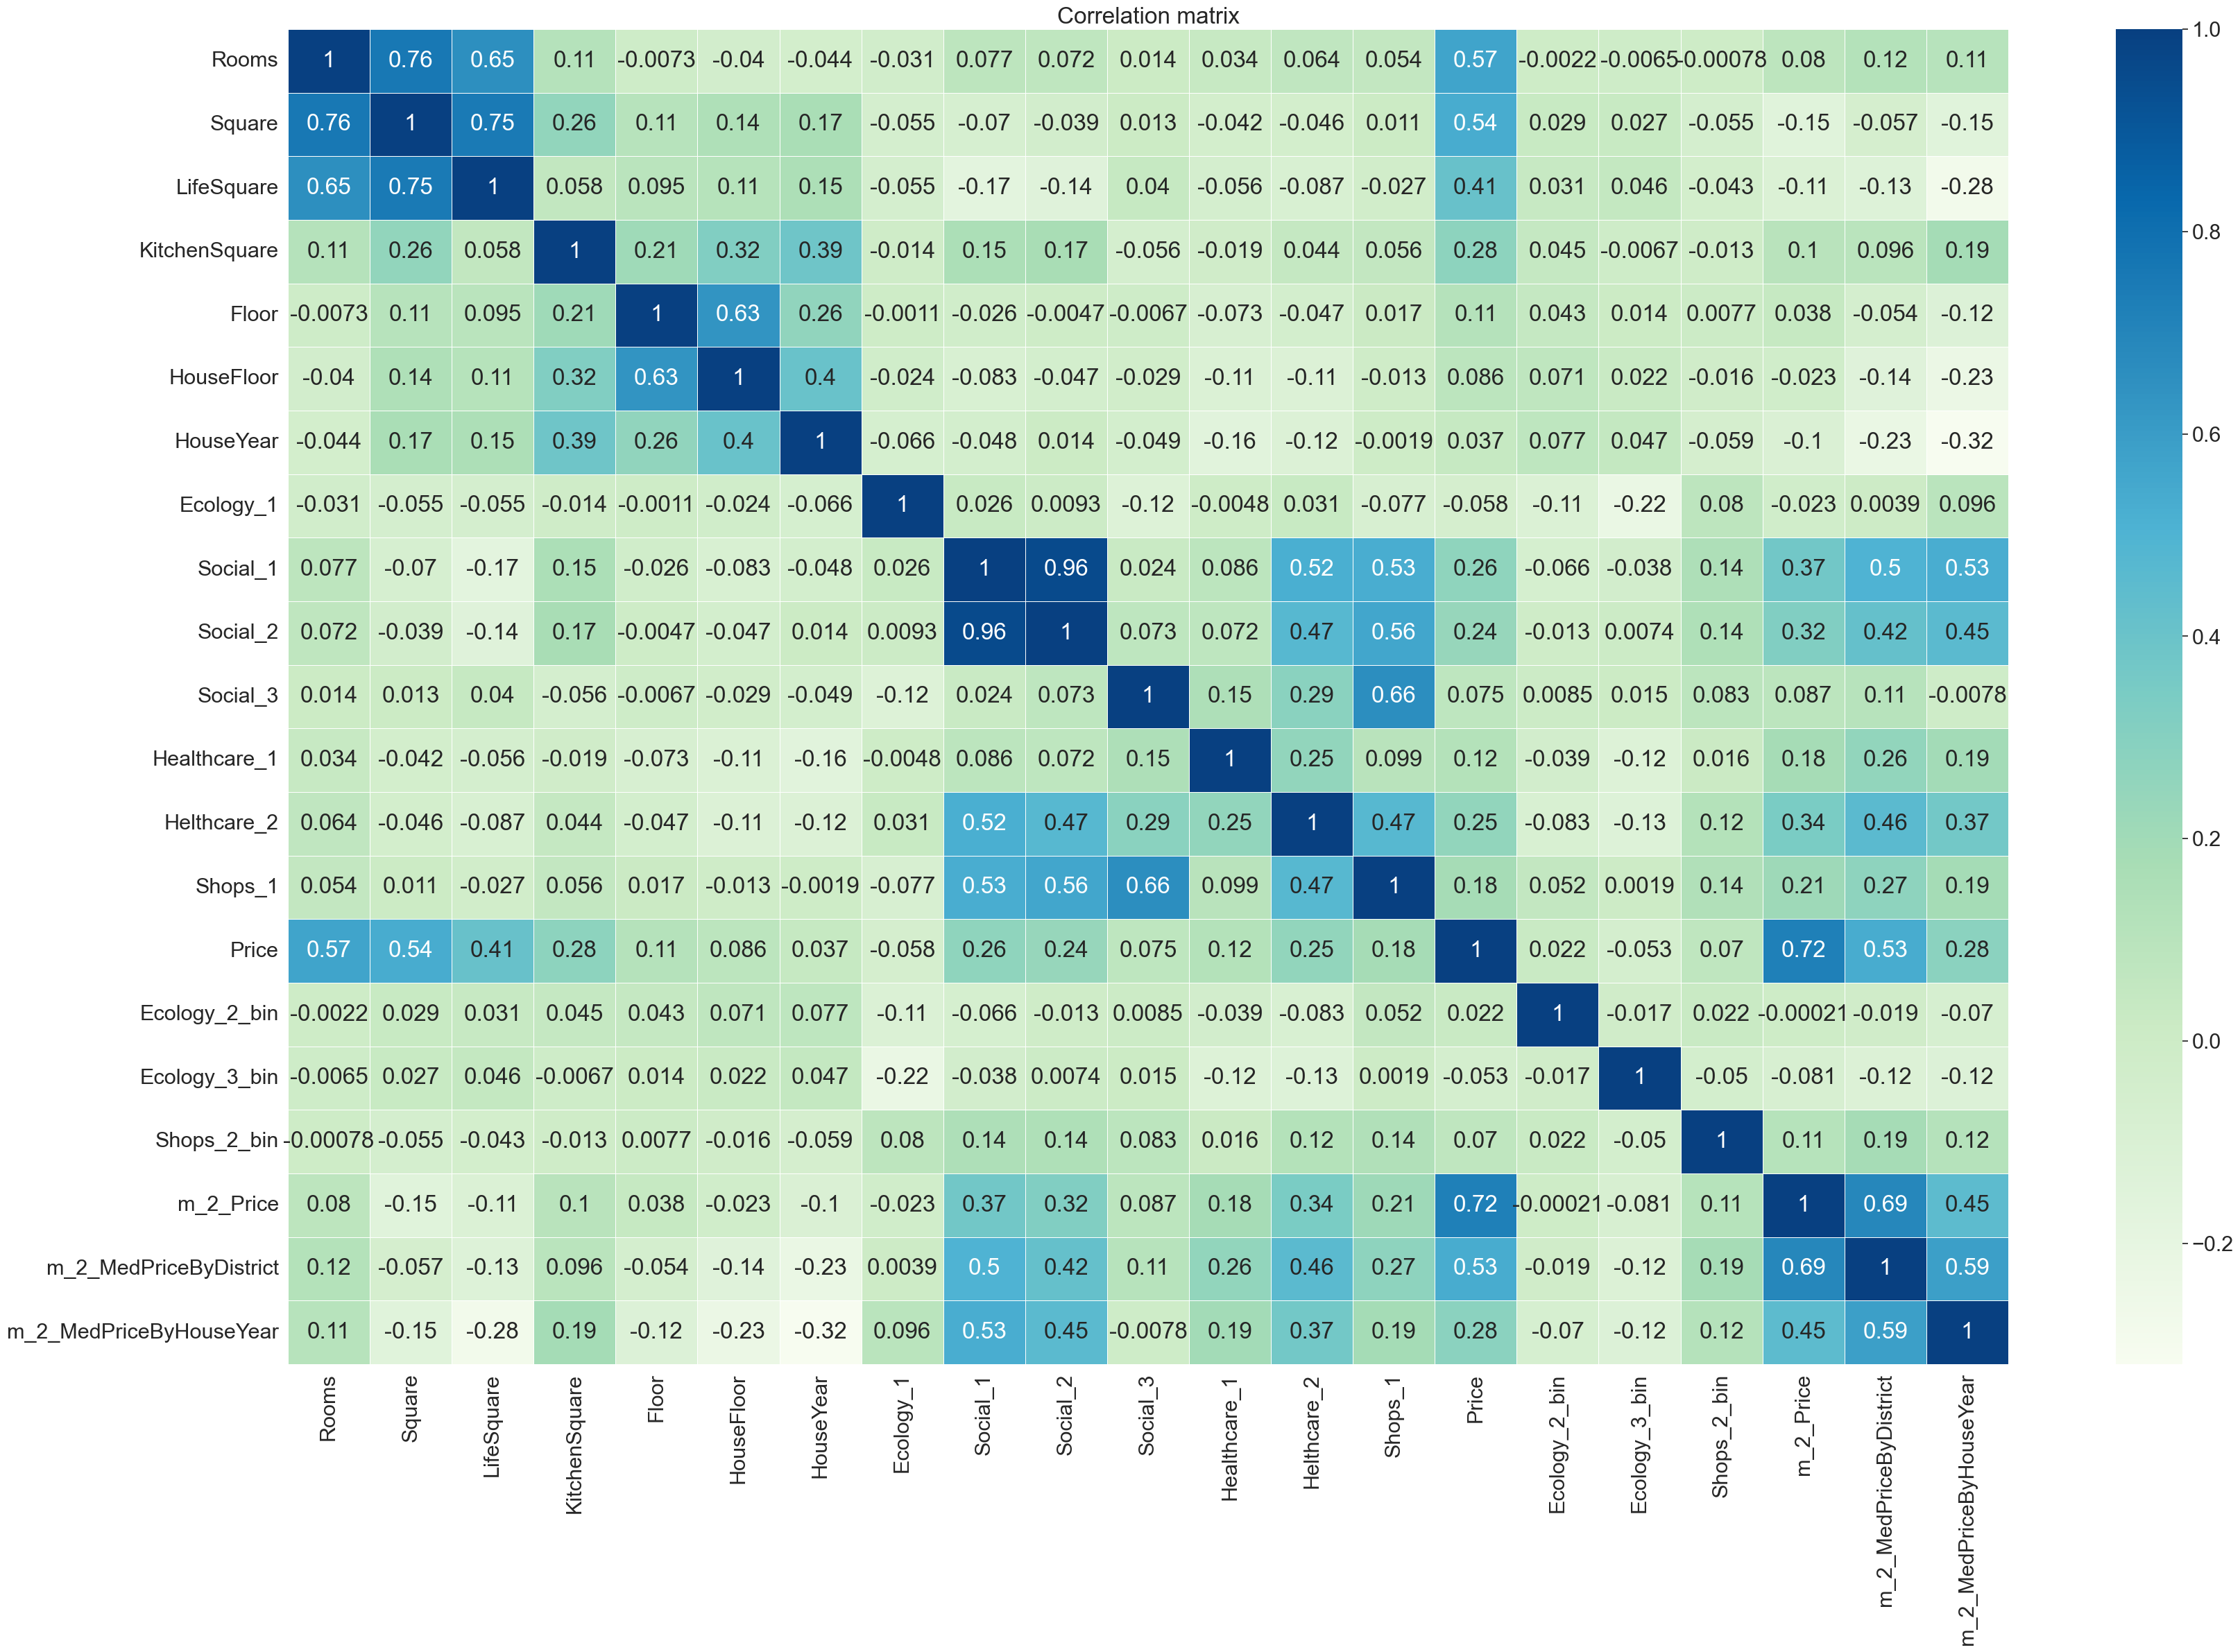

In [52]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [53]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [54]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,4358.274853,4473.255408,0.089040,33,5,0,11,1,1,1,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,4437.304072,4317.685445,0.000070,46,1,1,16,1,1,1,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,4862.207469,4429.204254,0.049637,34,0,1,3,1,1,1,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,2988.442425,2932.820032,0.437885,23,3,0,5,1,1,1,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,3992.031265,4367.263383,0.012339,35,1,2,4,1,1,1,150226.531644


# Масштабируем признаки

In [55]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [56]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,0.136936,-0.418667,-0.504022,-0.624152,-0.179408,-0.643767,-0.861917,0.399200,0.879736,-0.250529,0.474169,-0.127533,-0.883480,1.408356,0.09897,0.16816,0.299864,184966.930730
1,1.368379,0.707835,0.314410,0.427938,-0.179408,-0.643767,-0.373173,0.477878,0.672958,-0.998053,1.215681,-0.295384,-0.213923,2.448700,0.09897,0.16816,0.299864,300009.450063
2,0.136936,-0.611715,-0.522937,-0.624152,0.012637,-0.165758,-0.916222,0.900890,0.821185,-0.581588,0.531208,-0.337347,-0.213923,-0.256195,0.09897,0.16816,0.299864,220925.908524
3,0.136936,-0.076847,1.292966,0.953983,0.012637,0.630925,-0.427478,-0.964534,-1.167758,2.680470,-0.096225,-0.211458,-0.883480,0.159943,0.09897,0.16816,0.299864,175616.227217
4,-1.094506,-0.948911,-0.941262,-0.098107,0.588769,-0.165758,-0.481783,0.034587,0.738855,-0.894969,0.588247,-0.295384,0.455633,-0.048126,0.09897,0.16816,0.299864,150226.531644


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rooms                    10000 non-null  float64
 1   Square                   10000 non-null  float64
 2   LifeSquare               10000 non-null  float64
 3   KitchenSquare            10000 non-null  float64
 4   Floor                    10000 non-null  float64
 5   HouseFloor               10000 non-null  float64
 6   HouseYear                10000 non-null  float64
 7   m_2_MedPriceByDistrict   10000 non-null  float64
 8   m_2_MedPriceByHouseYear  10000 non-null  float64
 9   Ecology_1                10000 non-null  float64
 10  Social_1                 10000 non-null  float64
 11  Social_3                 10000 non-null  float64
 12  Helthcare_2              10000 non-null  float64
 13  Shops_1                  10000 non-null  float64
 14  Ecology_2_bin          

# Разбиваем на обучающую и валидационную выборку

In [58]:
X = df[feature_names]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=42)

In [59]:
rf_model = RandomForestRegressor (max_depth=400,
                                    max_features=7,
                                    random_state=42,
                                    n_estimators =1000,
                                  criterion='mse')

rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=400, max_features=7,
                      n_estimators=1000, random_state=42)

R2:	0.967


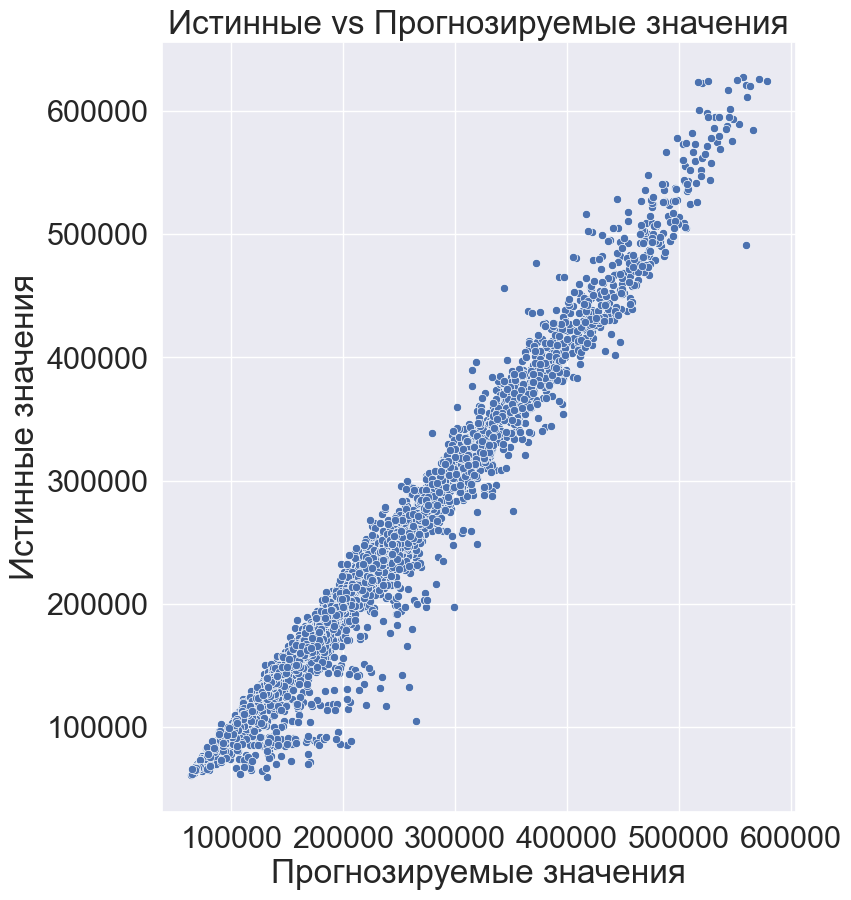

In [60]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds)

R2:	0.746


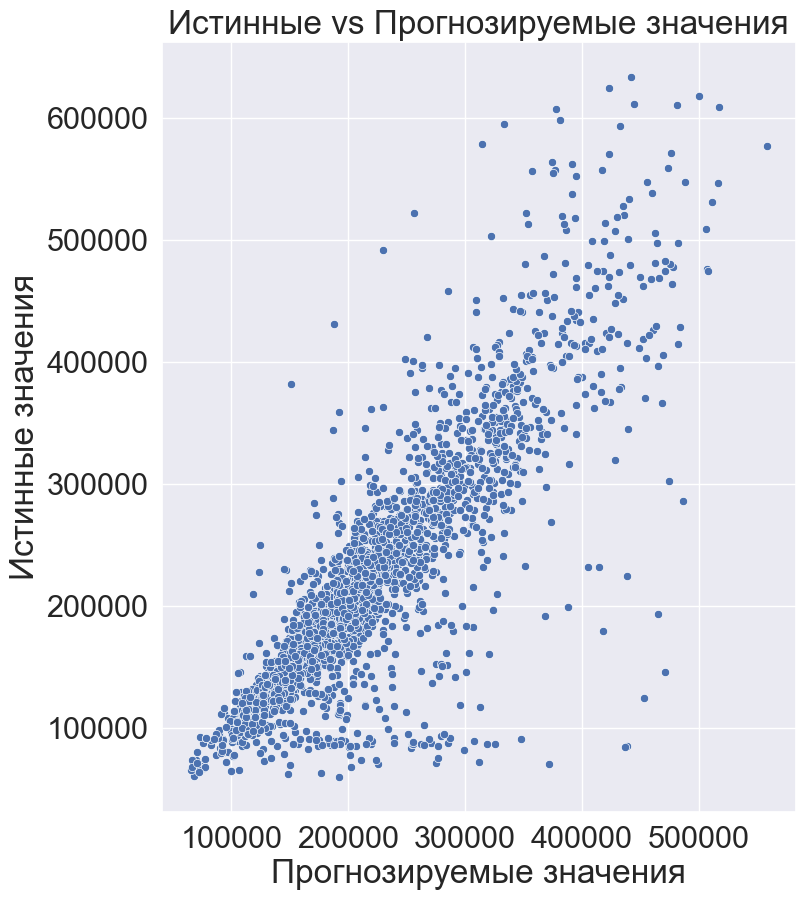

In [61]:
evaluate_preds(y_test, y_test_preds)

# Кросс-валидация

In [62]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.75042118, 0.74605724, 0.74288538, 0.76090611, 0.77373873])

In [63]:
cv_score.mean()

0.7548017268982219

# Важность признака

In [64]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,m_2_MedPriceByDistrict,0.234086
1,Square,0.223789
0,Rooms,0.151036
2,LifeSquare,0.078947
10,Social_1,0.063373
8,m_2_MedPriceByHouseYear,0.045644
11,Social_3,0.037460
6,HouseYear,0.031757
5,HouseFloor,0.025964
9,Ecology_1,0.025114


## Сохраняем результаты

In [65]:
stand_features = scaler.transform(test_df[feature_names])
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [66]:
X_test = test_df[feature_names]

In [67]:
y_test_preds = rf_model.predict(X_test)

In [68]:
y_test_preds

array([157942.18069124, 230023.39068722, 350097.58156621, ...,
       298984.22633605, 189041.64018678, 181812.34435029])

In [69]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_test_preds
preds.head(10)

,Id,Price
0,0,157942.180691
1,1,230023.390687
2,2,350097.581566
3,3,290566.361546
4,4,145821.083617
5,5,209962.821653
6,6,170753.301242
7,7,224971.532735
8,8,293260.558117
9,9,210057.854952


In [70]:
preds.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')